In [90]:
from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn

In [96]:
X = pd.read_csv('./target_vs_competitor_similarity_trend_across_runs_by_roi.csv')
A = pd.read_csv('./anchored_neural_changes_by_surfroi_and_subject.csv')

In [92]:
rois = np.unique(X.roi.values)
print 'Our ROIs:'
print rois

Our ROIs:
['EC' 'Fus' 'HC' 'IT' 'LOC' 'PHC' 'PRC' 'V1' 'V2']


In [5]:
X.groupby('roi')['slope'].mean()

roi
EC     0.002859
Fus    0.002278
HC     0.004494
IT     0.002625
LOC    0.000636
PHC    0.006652
PRC    0.002774
V1     0.000987
V2     0.001432
Name: slope, dtype: float64

In [57]:
plot_this = 0
if plot_this:
    which_roi = 'PHC'
    _X  = X[X['roi']==which_roi]
    h = plt.hist(_X.slope,bins=20)
    print np.mean(_X.slope)

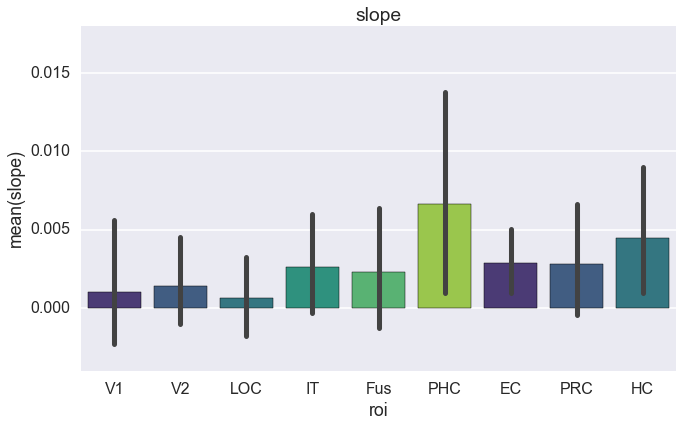

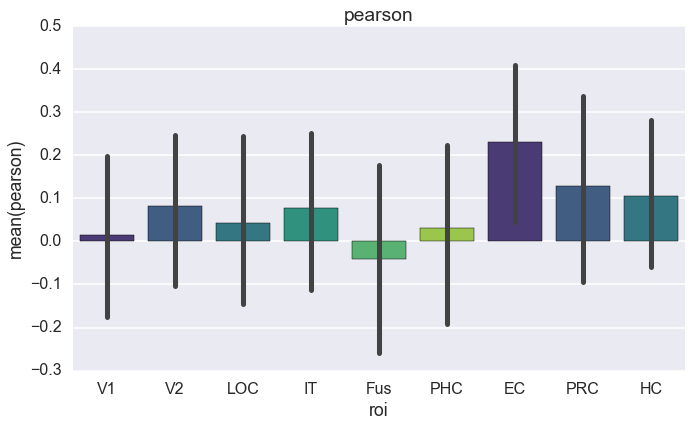

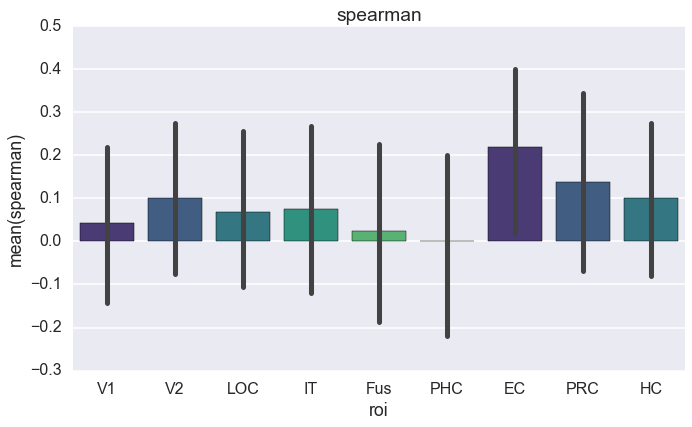

In [109]:
dvs = ['slope','pearson','spearman']
for dv in dvs:
    sns.set_context('poster')
    sns.set_style('darkgrid')
    plt.figure(figsize=(10,6))
    D = X.groupby('roi')[dv].mean()
    Y = pd.DataFrame(D).transpose()
    seq = ['V1','V2','LOC','IT','Fus','PHC','EC','PRC','HC']
    if dv=='slope':
        plt.ylim([-0.004,0.018])
    plt.ylabel(dv)
    colors = sns.color_palette("viridis", n_colors=6)
    plt.title(dv)
    plt.tight_layout()
    sns.barplot(x = 'roi',
                y = dv,
                data = X,
                order = seq,
                palette = colors)
    plt.savefig('./plots/neural_diff_across_runs_by_roi_{}.pdf'.format(dv))


In [81]:
def bootstrap_lt0(w,nIter=50000):
    boot = []
    for i in np.arange(nIter):
        boot.append(np.mean(np.random.choice(w,len(w),replace=True)))
    boot = np.array(boot) 
    p = sum(boot<0)/len(boot)*2
    lb = np.percentile(boot,2.5)
    ub = np.percentile(boot,97.5)
    print 'p = ' + str(sum(boot<0)/len(boot)*2)
    return boot, p, lb, ub

In [87]:
pearson_p = []
pearson_ci = []
for roi in rois:
    print roi
    _X = X[X['roi']==roi]
    boot,p, lb, ub = bootstrap_lt0(_X.pearson.values)
    pearson_p.append(p)
    pearson_ci.append([lb, ub])
    
spearman_p = []
spearman_ci = []
for roi in rois:
    print roi
    _X = X[X['roi']==roi]
    boot,p, lb, ub = bootstrap_lt0(_X.spearman.values)
    spearman_p.append(p)  
    spearman_ci.append([lb, ub])    
    
slope_p = []
slope_ci = []
for roi in rois:
    print roi
    _X = X[X['roi']==roi]
    boot,p, lb, ub = bootstrap_lt0(_X.slope.values)
    slope_p.append(p)  
    slope_ci.append([lb, ub])    

EC
p = 0.02132
Fus
p = 1.28808
HC
p = 0.2472
IT
p = 0.40932
LOC
p = 0.6828
PHC
p = 0.78228
PRC
p = 0.23912
V1
p = 0.87828
V2
p = 0.37968
EC
p = 0.02568
Fus
p = 0.81808
HC
p = 0.2548
IT
p = 0.4414
LOC
p = 0.48272
PHC
p = 1.0038
PRC
p = 0.19544
V1
p = 0.62948
V2
p = 0.32076
EC
p = 0.00388
Fus
p = 0.22744
HC
p = 0.00584
IT
p = 0.09508
LOC
p = 0.61764
PHC
p = 0.02344
PRC
p = 0.11668
V1
p = 0.64848
V2
p = 0.31292


In [94]:
X = pd.DataFrame([rois,pearson_p,spearman_p,slope_p])
X = X.transpose()
X.columns = ['roi','pearson','spearman','slope']
X

,roi,pearson,spearman,slope
0,EC,0.02132,0.02568,0.00388
1,Fus,1.28808,0.81808,0.22744
2,HC,0.2472,0.2548,0.00584
3,IT,0.40932,0.4414,0.09508
4,LOC,0.6828,0.48272,0.61764
5,PHC,0.78228,1.0038,0.02344
6,PRC,0.23912,0.19544,0.11668
7,V1,0.87828,0.62948,0.64848
8,V2,0.37968,0.32076,0.31292


### prepost neural differentiation vs. during-drawing neural differentiation -- individual differences

In [164]:
A = pd.read_csv('./anchored_neural_changes_by_surfroi_and_subject.csv')

V1_diff = A.trained_V1.values - A.control_V1.values
V2_diff = A.trained_V2.values - A.control_V2.values
LOC_diff = A.trained_LOC.values - A.control_LOC.values
IT_diff = A.trained_IT.values - A.control_IT.values
fusiform_diff = A.trained_fusiform.values - A.control_fusiform.values
parahippo_diff = A.trained_parahippo.values - A.control_parahippo.values
PRC_diff = A.trained_PRC.values - A.control_PRC.values
ento_diff = A.trained_ento.values - A.control_ento.values
hipp_diff = A.trained_hipp.values - A.control_hipp.values


A = A.assign(V1_diff=pd.Series(V1_diff).values)
A = A.assign(V2_diff=pd.Series(V2_diff).values)
A = A.assign(LOC_diff=pd.Series(LOC_diff).values)
A = A.assign(IT_diff=pd.Series(IT_diff).values)
A = A.assign(fusiform_diff=pd.Series(fusiform_diff).values)
A = A.assign(parahippo_diff=pd.Series(parahippo_diff).values)
A = A.assign(PRC_diff=pd.Series(PRC_diff).values)
A = A.assign(ento_diff=pd.Series(ento_diff).values)
A = A.assign(hipp_diff=pd.Series(hipp_diff).values)

In [172]:
A2 = A.loc[:,'V1_diff':'hipp_diff']

# A = X.groupby('roi')[dv].mean()
# Y = pd.DataFrame(D).transpose()

In [176]:
yvals = A2.mean(0)
sem = A2.std(0)/np.sqrt(len(A2))

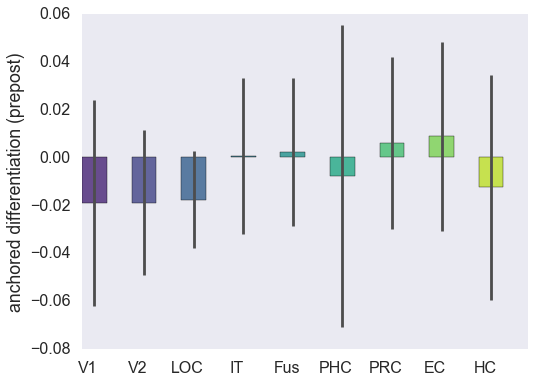

In [185]:
sns.set_style('dark')
sns.set_context('poster')
fig = plt.figure(figsize=(8,6))

n_groups = 9 # num ROIs
index = np.arange(n_groups)
bar_width = 0.5

opacity = 0.8
error_config = {'ecolor': '0.3'}
colors = sns.color_palette("viridis", n_colors=9)
plt.ylabel('anchored differentiation (prepost)')

rects = plt.bar(index, yvals, bar_width,
                 alpha=opacity,
                 color=colors,
                 yerr=sem*2,
                 error_kw=error_config)
tick = plt.xticks(index + bar_width / 4, ('V1','V2','LOC','IT','Fus','PHC','PRC','EC','HC'))

plt.savefig('./plots/prepost_anchored_differentiation_by_roi.pdf')

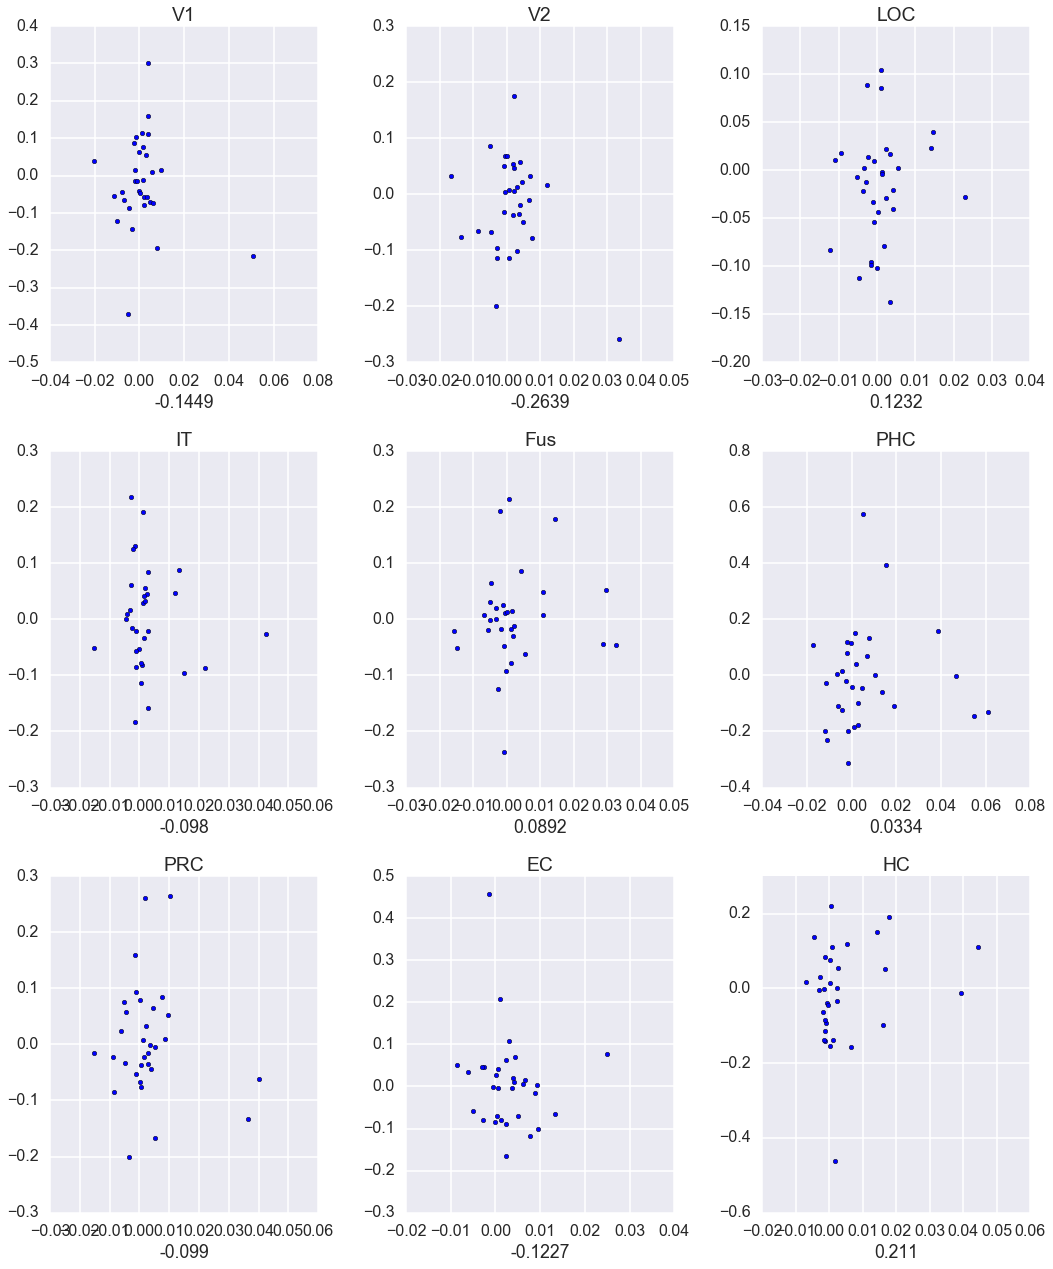

In [112]:
sns.set_context('poster')
rois_x = ['V1','V2','LOC','IT','Fus','PHC','PRC','EC','HC']
rois_y = ['V1','V2','LOC','IT','fusiform','parahippo','PRC','ento','hipp']
x2y = dict(zip(rois_x,rois_y))
fig = plt.figure(figsize=(15,18))
for i,which_roi in enumerate(rois_x):
    plt.subplot(3,3,i+1)
    _X = X[X['roi']==which_roi]
    x = _X.slope.values
    y = A['{}_diff'.format(x2y[which_roi])]
    plt.scatter(x,y)
    plt.title(which_roi)
    plt.xlabel(np.round(stats.pearsonr(x,y)[0],4))
plt.tight_layout()
    

### neural differentiation vs. sketch differentiation (individual differences)

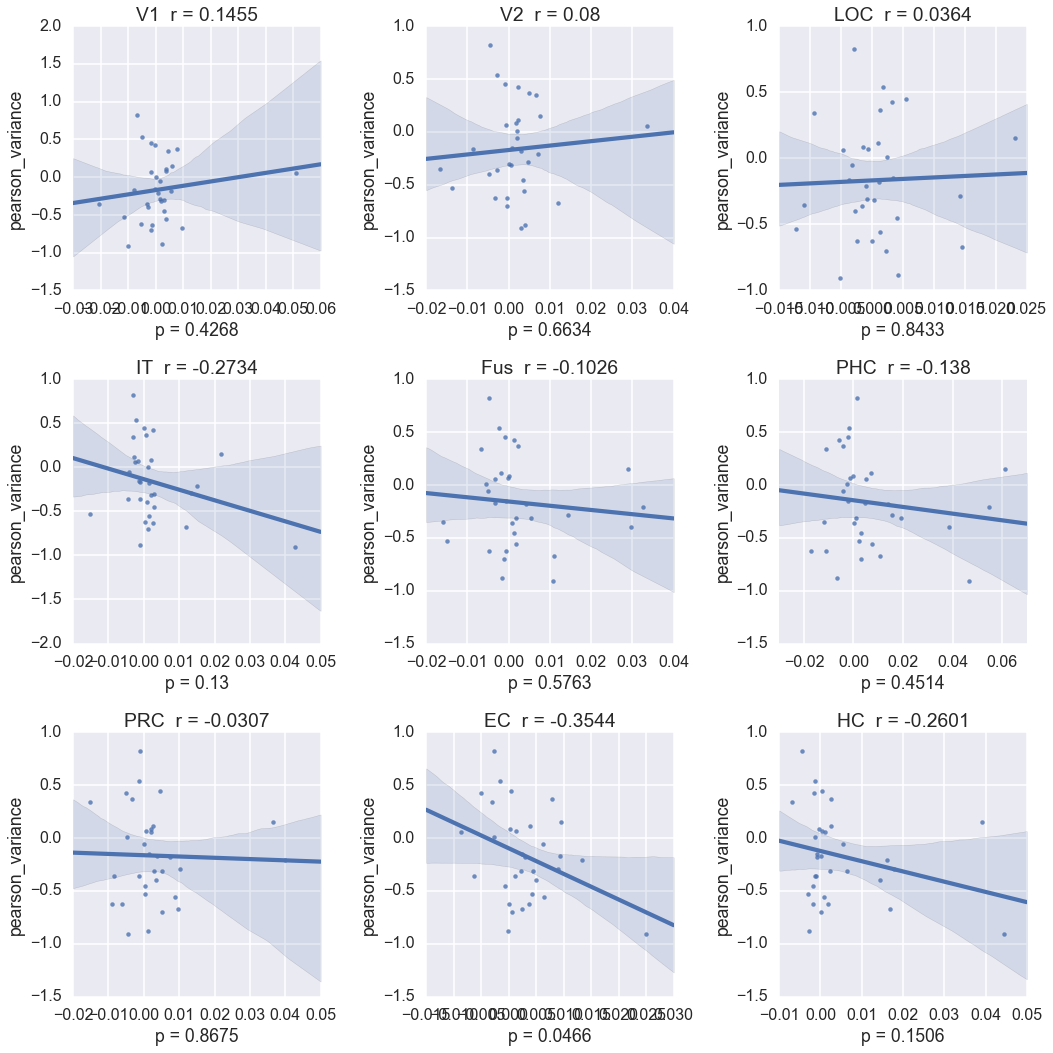

In [139]:
V = pd.read_csv('~/sketchfeat/sketches/sketch_variance_timecourse_across_runs_fc7.csv')
rois_x = ['V1','V2','LOC','IT','Fus','PHC','PRC','EC','HC']
rois_y = ['V1','V2','LOC','IT','fusiform','parahippo','PRC','ento','hipp']
x2y = dict(zip(rois_x,rois_y))
fig = plt.figure(figsize=(15,15))
vals = []
for i,which_roi in enumerate(rois_x):
    plt.subplot(3,3,i+1)
    _X = X[X['roi']==which_roi]
    _X = _X.sort_values(['subject'])    
    x = _X.slope.values
    y = V[V['subj'].isin(_X.subject.values)]['pearson_variance']
    sns.regplot(x,y,fit_reg=True)
    plt.title('{}  r = {}'.format(which_roi, np.round(stats.pearsonr(x,y)[0],4)))
    plt.xlabel('p = {}'.format(np.round(stats.pearsonr(x,y)[1],4)))
    vals.append(stats.pearsonr(x,y)[0])
plt.tight_layout()



In [140]:
def r_to_z(r):
    return math.log((1 + r) / (1 - r)) / 2.0

def z_to_r(z):
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def r_confidence_interval(r, alpha, n):
    z = r_to_z(r)
    se = 1.0 / math.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se

    # Return a sequence
    return (z_to_r(lo), z_to_r(hi))

def get_r_CIs(vals,N):
    ci = []
    lerr = []
    uerr = []
    for v in vals:
        ci.append(r_confidence_interval(v,0.05,N))
        lerr.append(v - r_confidence_interval(v,0.05,N)[0])
        uerr.append(r_confidence_interval(v,0.05,N)[1] - v) 
    ERRBAR = np.vstack((lerr,uerr))        
    CI = np.array(ci).transpose()
    return CI, ERRBAR

In [142]:
import math
CI,ERRBAR = get_r_CIs(vals,len(x))

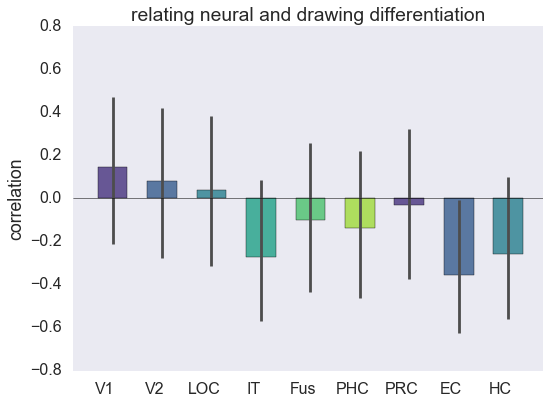

In [163]:
sns.set_style('dark')
sns.set_context('poster')
fig = plt.figure(figsize=(8,6))

n_groups = len(rois_x) # num ROIs
index = np.arange(n_groups)
bar_width = 0.6

_vals = vals
_ERRBAR = ERRBAR

opacity = 0.8
error_config = {'ecolor': '0.3'}
colors = sns.color_palette("viridis", n_colors=6)


rects = plt.bar(index, _vals, bar_width,
                 alpha=opacity,
                 color=colors,
                 yerr=_ERRBAR,
                 error_kw=error_config)
tick = plt.xticks(index + bar_width / 4, rois_x)
plt.title('relating neural and drawing differentiation')
plt.ylabel('correlation')
plt.axhline(y=0,color='k',linewidth=0.5)
plt.ylim(-0.8,0.8)
plt.xlim([-0.5,9])
plt.tight_layout()
if not os.path.exists('./plots'):
    os.makedirs('./plots')
plt.savefig('./plots/correlation_neural_during_drawing_changes_allrois_{}.pdf'.format('fc7'))